# Tutorial home sales

In [23]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
# Grid Search

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 화장실의 수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : Has been viewed
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 주차 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [24]:
addr = "./data/"
df_train = pd.read_csv(os.path.join(addr,'train.csv'))
df_test = pd.read_csv(os.path.join(addr,'test.csv'))

df_train.info()

df_train.head()

df_test.info()

df_test.head()

# EDA

#### 1. Check missing data

def check_missing(df):
    print("Number of Missing data at each column")
    for column in df.columns:
        a = df[column].isnull().sum()
        print(f"{column:20} :{a}")

check_missing(df_train)
print()
check_missing(df_test)

df_train.drop(['sqft_living', 'sqft_lot'],axis=1, inplace=True)
df_test.drop(['sqft_living', 'sqft_lot'], axis=1, inplace=True)

df_train.shape, df_test.shape

In [25]:
df_train["date"] = df_train["date"].apply(lambda x: int(x[:8]))
df_test["date"] = df_test["date"].apply(lambda x: int(x[:8]))

In [26]:
df_train["year"] = df_train.date.apply(lambda x: x // 10000)
df_train["month"] = df_train.date.apply(lambda x: (x%10000) // 100)
df_test["year"] = df_test.date.apply(lambda x: x // 10000)
df_test["month"] = df_test.date.apply(lambda x: (x%10000) // 100)

In [27]:
df_train.drop(["date"],axis=1, inplace=True)
df_test.drop(["date"],axis=1, inplace=True)

In [28]:
lambda_fn = lambda row : row['year'] - row['yr_renovated'] if row['yr_renovated'] else row['year'] - row['yr_built']
df_train["age"] = df_train.apply(lambda_fn, axis=1)
df_test["age"] = df_test.apply(lambda_fn, axis=1)

def apply_func(func, df, *args):
    for col in args:
        df[col]=func(df[col])

apply_func(minmax_scale, df_train, *["age", "month"])
apply_func(minmax_scale, df_test, *["age", "month"])

target_attributes = ["sqft_living15","sqft_lot15", "sqft_above", "sqft_basement","yr_built"]
apply_func(minmax_scale, df_train, *target_attributes)
apply_func(minmax_scale, df_test, *target_attributes)

target_attributes = ["lat","long"]
apply_func(scale, df_train, *target_attributes)
apply_func(scale, df_test, *target_attributes)

df_train.drop(['year'],axis=1,inplace=True)

In [29]:
corr = df_train.corr()

In [30]:
cmap = sns.diverging_palette(220,10, as_cmap=True)

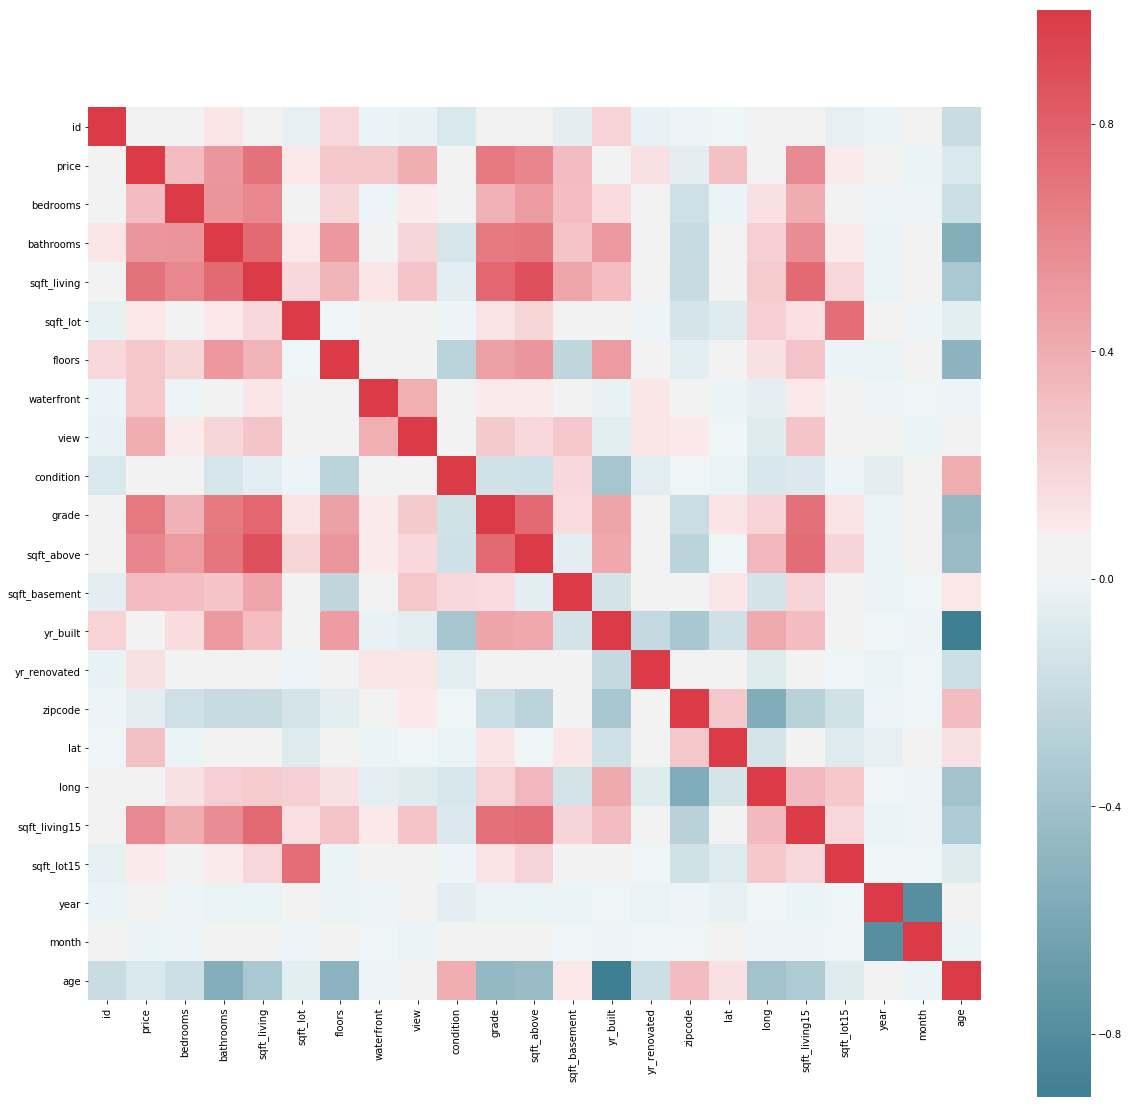

In [31]:
fig,ax = plt.subplots(1,1, figsize=(20,20))
sns.heatmap(corr, cmap = cmap, square = True, ax=ax)

In [ ]:
drop_list = ['month', 'yr_built','sqft_living','sqft_lot']
df_train.drop(columns=drop_list,axis=1,inplace=True)

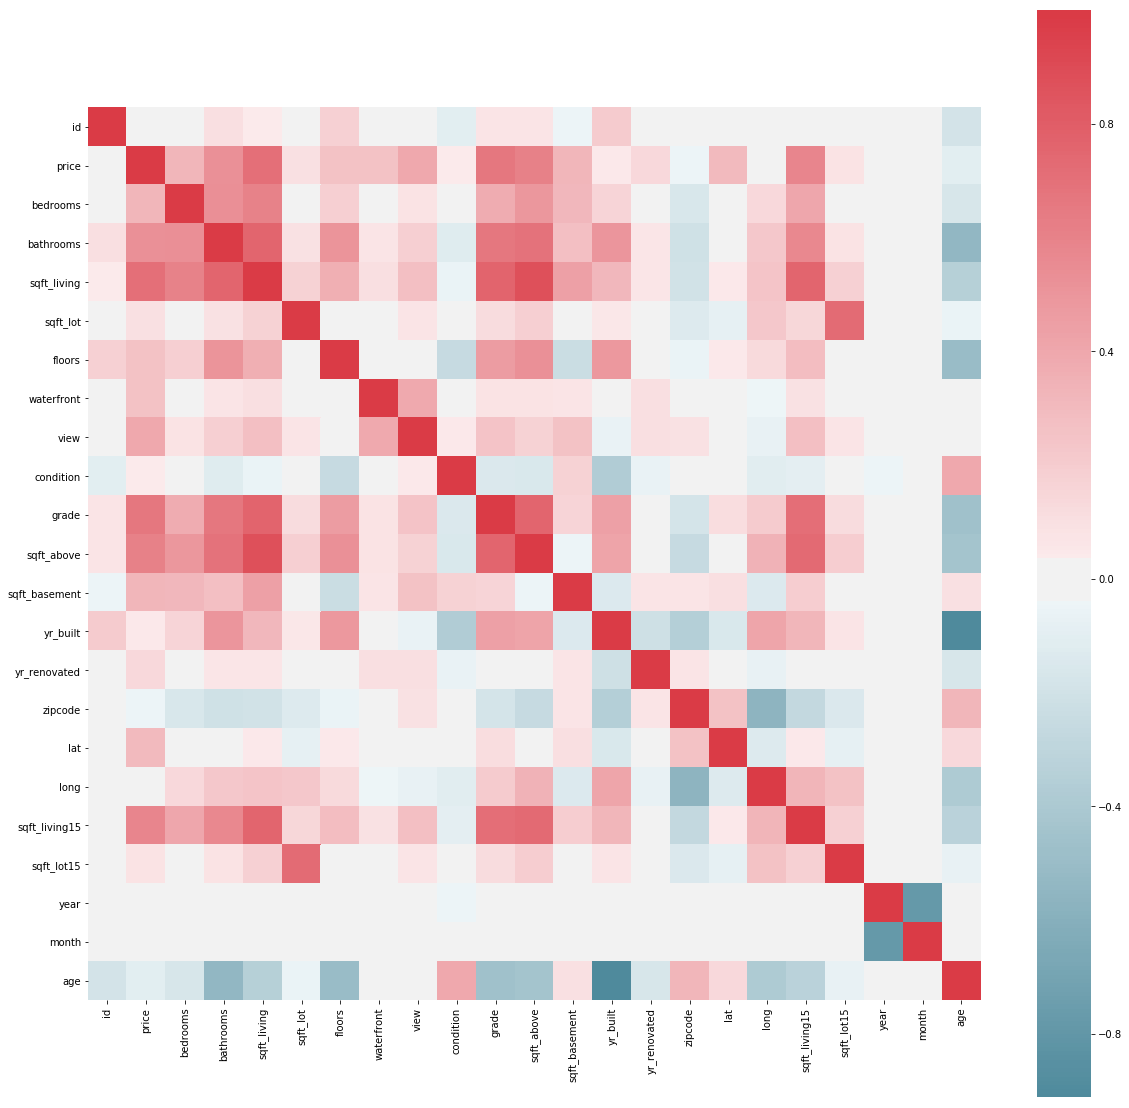

In [32]:
corr = df_train.corr()
fig,ax = plt.subplots(1,1, figsize=(20,20))
sns.heatmap(corr, cmap = cmap, square = True, ax=ax, center=0)

In [50]:
y_tr = df_train["price"]
df_train2 = df_train.drop(['price','id'],axis=1)

In [51]:
print(df_train2.columns)
df_train2.head()

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month', 'age'],
      dtype='object')


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,age
0,3,1.00,7.073270,5650,1.0,0,0,3,7,1180,...,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,59.0
1,2,1.00,6.646391,10000,1.0,0,0,3,6,770,...,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,82.0
2,3,2.00,7.426549,8080,1.0,0,0,3,8,1680,...,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,28.0
3,3,2.25,7.447168,6819,2.0,0,0,3,7,1715,...,1995,0,98003,47.3097,-122.327,2238,6819,2014,6,19.0
4,3,1.50,6.966024,9711,1.0,0,0,3,7,1060,...,1963,0,98198,47.4095,-122.315,1650,9711,2015,1,52.0


In [35]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures, normalize
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import scale, minmax_scale

In [53]:
ridge = linear_model.Ridge()
model = Pipeline([('poly', PolynomialFeatures(degree=2)), ('pca',PCA()),('linear',ridge)])

In [54]:
model.fit(df_train2.values, y_tr.values)

c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.561412e-26
  overwrite_a=True).T


Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('linear', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [55]:
pred = model.predict(df_train2.values)
print(mean_squared_error(pred, y_tr.values)**0.5)

a = pd.DataFrame({"pred":pred,"target":y_tr.values})

146798.56373836647


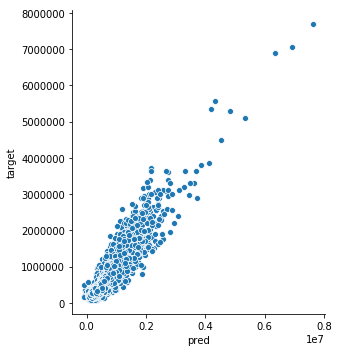

In [56]:
sns.relplot(x='pred',y='target', data=a)

In [61]:
optm = 150000
log = []

def apply_fcn(df,col,fcn):
    df[col] = df[col].apply(lambda x: fcn(x))

def apply_to_col(df,col,fcn):
    df[col] = fcn(df[col])
    
def get_metric(col, fcn, flag):
    global df_train
    global optm
    global log
    df_train2 = df_train.drop(['price','id'],axis=1)
    if flag:
        apply_fcn(df_train2,col,fcn)
    else:
        apply_to_col(df_train2, col, fcn)

    ridge = linear_model.Ridge()
    model = Pipeline([('poly', PolynomialFeatures(degree=2)), ('linear',ridge)])
    model.fit(df_train2.values, y_tr.values)
    pred = model.predict(df_train2.values)
    a = mean_squared_error(pred, y_tr.values)**0.5
    print(f"{col} : {a}")
    if a < optm:
        optm = a
        log.append([col,fcn])
    
def find_columns(cols, fcn, flag = True):
    
    for col in cols:
        get_metric(col, fcn, flag)

In [42]:
fg = lambda x: np.log(x) if x > 0 else np.log(abs(x)+0.01)

In [64]:
find_columns(df_train2.columns, minmax_scale, False)

c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


bedrooms : 146804.14772163454
bathrooms : 146907.62365200117
sqft_living : 147715.3489384231


c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


sqft_lot : 146999.41124080704
floors : 146839.0133198647


c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


waterfront : 146798.56373828865


c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


view : 146797.30686775548


c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


condition : 146805.57915790653


c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


grade : 147192.8168028944


c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


sqft_above : 148899.1119601364


c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


sqft_basement : 147566.98654765316
yr_built : 146896.0001841493


c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.177180e-26
  overwrite_a=True).T
c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.663839e-26
  overwrite_a=Tr

yr_renovated : 146881.38879658259
zipcode : 147053.55928025566
lat : 146433.54300619505
long : 146929.08035045164


c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


sqft_living15 : 146916.29147277525


c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


sqft_lot15 : 146985.7021286839
year : 147059.0031125858


c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.611868e-26
  overwrite_a=True).T
c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


month : 146798.0128917551
age : 146993.84555700622


c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.855286e-26
  overwrite_a=True).T


In [44]:
apply_fcn(df_train,'sqft_living',fg)

In [ ]:
get_metric('sqft_above',fg)

In [ ]:
# interested = ["price", "month", "floors", "lat", "long","sqft_above","rooms"]
# sns.pairplot(data=df_train, hue="waterfront", vars=interested)

#### one-hot encoding

df_train = pd.get_dummies(df_train, columns=["zipcode"], prefix="zip")
df_test = pd.get_dummies(df_test, columns=["zipcode"], prefix="zip")

# df_train_1 = df_train.loc[df_train['condition']<=2]
# df_train_2 = df_train[df_train['condition']>2]
# df_test_1 = df_train.loc[df_train['condition']<=2]
# df_test_2 = df_train[df_train['condition']>2]

In [67]:
poly = PolynomialFeatures(degree = 2)

In [68]:
poly.fit(df_train2.values)

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)

In [69]:
X = poly.transform(df_train2.values)

In [70]:
X.shape

(15035, 253)

In [73]:
y= y_tr.values

In [74]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

In [87]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'},{'model':linear_model.Ridge(alpha=0.01), 'name':"ridge"}]

In [88]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], X, y)), 
                                             cv=kfold))

In [89]:
get_cv_score(models)

c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Model GradientBoosting CV score : 0.8538


c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Model XGBoost CV score : 0.8516


c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Model LightGBM CV score : 0.8695


c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Model ridge CV score : 0.8073
